In [1]:
#Use a short time of frames to calbirate the camera#
from geometry import gen_focal_length
from camera_utils import Camera, AerialView
from geometry_3d import Rotation
from calib_losses import constrained_alpha_beta_fov_loss
import numpy as np
import os
import cv2
from scipy import optimize
import argparse
import json

from visualize import create_black_board, draw_text, vis_xyz_as_images, vis_box_pairs
# from datasets_v3 import BoxDataLoader
from datasets_v3_v2 import BoxDataLoader
from utils import load_seq_info, save_to_json

from const import MOT17_SEQ_NAMES, MOT17_TRAIN_SEQ_NAMES, MOT20_TRAIN_SEQ_NAMES, RANDOM_COLORS
from yolox.camera.img_vis import draw_box, draw_corners, draw_boxes

import time

def gen_dir(folder):
    if not os.path.exists(folder): 
        os.system(f'mkdir -p {folder}')

def get_box_pts(boxes, 
                loc = 'bottom'):
    if loc == 'center':
        box_pts = boxes[:, :2] + boxes[:, 2:] / 2
    elif loc == 'bottom':
        box_pts = boxes[:, :2].copy()
        box_pts[:, 0] += boxes[:, 2] / 2 # x + w/2
        box_pts[:, 1] += boxes[:, 3]     # y + h
    return box_pts

def get_xy_ranges(a_view, tracks):

    boxes = tracks.reshape((-1, 4))
    mask  = boxes[:, 2] * boxes[:, 3] > 0
    boxes = boxes[mask]

    xyh = a_view.compute_xyh_from_boxes(boxes)
    xmin, xmax = xyh[:, 0].min(), xyh[:, 0].max()
    ymin, ymax = xyh[:, 1].min(), xyh[:, 1].max()

    return [xmin, ymin, xmax, ymax]


def dec_calib(boxes, bounds, a_view, 
              use_core = True):

    alpha, beta, fov = bounds

    new_boxes = boxes.copy()
    if use_core:
        centers = boxes.copy()
        centers[:, :, :2] += boxes[:, :, 2:] / 2
        centers[:, :, 2]   = centers[:, :, 3] / 4
        centers[:, :, :2] -= centers[:, :, 2:] / 2
        new_boxes          = centers

    params  = (a_view, new_boxes)
    result  = optimize.differential_evolution(constrained_alpha_beta_fov_loss, [alpha, beta, fov], args = params, 
                    updating='deferred', tol = 1e-10, workers=20, disp = False, popsize=50)

    alpha, beta, fov = result.x

    return np.array([alpha, beta, fov]), result.fun

def get_params():
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_name", type=str, default = 'mot')
    parser.add_argument("--subset",       type=str, default = 'train')    
    parser.add_argument("--seq_name",     type=str, default = 'MOT17-13-FRCNN')
    parser.add_argument("--use_gt",       action="store_true", help="use ground truth or not")
    parser.add_argument("--workers",      type=int, default = 20)
    parser.add_argument("--popsize",      type=int, default = 50) 
    parser.add_argument("--start",        type=int, default = 0)
    parser.add_argument("--window",       type=int, default = 3)
    args = parser.parse_args()
    return args

/home/shenghua/miniconda3/envs/pt3_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# args = get_params()
# print(args)
root_dir = os.path.abspath('../')
# proj_name    = 'calib_v3'         # dynamic update for a moving camera
# dataset_name = args.dataset_name
# subset       = args.subset
# seq_name     = args.seq_name

# use_gt   = args.use_gt

dataset_name = 'mot'
subset       = 'train'
seq_name     = 'MOT17-13-FRCNN'

use_gt       = True
use_core     = True
multi_ecc    = True
time_window  = 4

print('------------------------------------------------\n')
seq_info_file = os.path.join(root_dir, 'datasets', 
                    dataset_name, subset,  seq_name, 'seqinfo.ini')
seq_info = load_seq_info(seq_info_file)
print(seq_info)

calib_res_dir = os.path.join(root_dir, 'calib_results_v2', dataset_name)
gen_dir(calib_res_dir)

# intialize aerial view objects for calibration
w_img, h_img = seq_info['w_img'], seq_info['h_img']
rotation     = Rotation(np.array([0, 0, 0]))
camera       = Camera(w_img = w_img, h_img = h_img, 
                        cx = w_img / 2, cy = h_img / 2)

a_view        = AerialView(camera, rotation)

# load data for calibration
if use_gt:
    track_file = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'gt/gt.txt')
else:
    if seq_name in MOT17_SEQ_NAMES:
        track_file = os.path.join(root_dir, 'results', f'mot17_paper_v3/bytetrack/{seq_name}.txt')
    else:
        track_file = os.path.join(root_dir, 'results', f'mot20_paper/yolox_x_mix_mot20_ch/bytetrack/{seq_name}.txt')

boxloader    = BoxDataLoader(track_file = track_file,
                            img_size           = (w_img, h_img),
                            window             = int(seq_info['fps'] * 2),
                            stride             = seq_info['fps'] // 2,
                            height_dif_thresh  = 3,
                            front_ratio_thresh = 0.8,
                            multi_ecc          = multi_ecc,
                            fps                = seq_info['fps'],
                            img_dir            = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'img1'),
                            time_window        = time_window)

mask = boxloader.raw_tracks[:, 0, -1] > 0
print(mask.sum())

------------------------------------------------

{'seq_name': 'MOT17-13-FRCNN', 'fps': 25, 'seq_len': 750, 'w_img': 1920, 'h_img': 1080}
track numpy shape: (188, 750, 4)
track numpy shape: (188, 750, 4)
22


In [3]:
import cv2 as cv
# init ECC module
number_of_iterations = 50
termination_eps = 0.001
# Define termination criteria
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

def ecc(frame, ref, dsample = 4):
    h, w              = frame.shape[:2]
    h, w              = h // dsample, w // dsample
    frame             = cv.resize(frame, (w, h))
    ref               = cv.resize(ref,   (w, h))
    warp_matrix       = np.eye(3, 3, dtype=np.float32)
    gray_frame        = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    ref_frame         = cv.cvtColor(ref, cv.COLOR_BGR2GRAY)
    (cc, warp_matrix) = cv.findTransformECC(gray_frame, ref_frame, warp_matrix, cv.MOTION_HOMOGRAPHY, criteria)
    return warp_matrix

def gen_ecc_coefficients(img_dir, fps = 30, time_window = 3, num_frames = 200):

    # tracks       = tracks[:, :num_frames, :].copy()
    frame_window = int(fps * time_window)
    # num_frames   = tracks.shape[1]
    ecc_coefs    = np.tile(np.eye(3, 3).reshape((1, 3, 3)), (num_frames, 1, 1))
    for frame_id in range(num_frames):
        print(f'frame id : {frame_id}')
        ind_window = frame_id // frame_window
        if frame_id == ind_window * frame_window + frame_window // 2: continue
        if frame_id % frame_window == 0:
            ref_frame    = cv.imread(img_dir + '/{:06d}.jpg'.format(frame_id + frame_window // 2))
        frame = cv.imread(img_dir + '/{:06d}.jpg'.format(frame_id + 1))
        # ecc
        ecc_coef  = ecc(frame, ref_frame)
        ecc_coefs[frame_id, :] = ecc_coef
    
    return ecc_coefs

def map_to_ref(ecc_coefs, tracks, dsample = 4):
    EPS = 1e-10

    tracks    = tracks.copy() / dsample
    ecc_coefs = np.expand_dims(ecc_coefs, axis = 0)
    ecc_coefs = np.tile(ecc_coefs, (tracks.shape[0], 1, 1, 1))
    
    # track shape
    n, f   = tracks.shape[:2]

    mask   = tracks[:, :, -1] > 0

    tracks = tracks.reshape((-1, 4))

    t         = tracks[:, :2].copy()
    t[:, 0]  += tracks[:, 2] / 2
    
    r         = tracks[:, :2].copy()
    r[:, 0]  += tracks[:, 2]
    r[:, 1]  += tracks[:, 3] / 2

    b         = tracks[:, :2].copy()
    b[:, 0]  += tracks[:, 2] / 2
    b[:, 1]  += tracks[:, 3]

    l         = tracks[:, :2].copy()
    l[:, 1]  += tracks[:, 3] / 2

    trbl      = np.stack([t, r, b, l], axis = 0)
    trbl      = trbl.reshape((-1, 2))
    trbl      = np.concatenate([trbl, np.ones((4 * n * f, 1))], axis = -1)  # n * f * 4, 3
    trbl      = np.expand_dims(trbl, axis = -1)
    
    new_coefs = np.tile(ecc_coefs, (4, 1, 1)).reshape((-1, 3, 3))         # n * f * 4, 3, 3

    new_trbl  = np.matmul(new_coefs, trbl)                                # n * f * 4, 3, 1
    
    new_trbl  = new_trbl.squeeze()
    new_trbl  = new_trbl[:, :2] / (new_trbl[:, 2:] + EPS)

    new_trbl  = new_trbl.reshape((4, n, f, 2))
    new_trbl  = new_trbl.transpose((1, 2, 0, 3))

    xmin, xmax  = new_trbl[:, :, :, 0].min(axis = -1), new_trbl[:, :, :, 0].max(axis = -1)
    ymin, ymax  = new_trbl[:, :, :, 1].min(axis = -1), new_trbl[:, :, :, 1].max(axis = -1)

    new_tracks  = np.zeros(new_trbl.shape[:3])
    ecc_tracks  = new_tracks.copy()
    new_tracks[:, :, 0] = xmin
    new_tracks[:, :, 1] = ymin
    new_tracks[:, :, 2] = xmax - xmin
    new_tracks[:, :, 3] = ymax - ymin

    ecc_tracks[mask]    = new_tracks[mask]

    ecc_tracks = ecc_tracks * dsample

    return ecc_tracks

def gen_ecc_coefficients_v2(img_dir, fps = 30, time_window = 3, num_frames = 200):

    frame_window = int(fps * time_window)
    # num_frames   = self.tracks.shape[1]
    ecc_coefs    = np.tile(np.eye(3, 3).reshape((1, 3, 3)), (num_frames, 1, 1))
    for frame_id in range(num_frames):
        print(f'frame id : {frame_id}')
        ind_window   = frame_id // frame_window
        ref_frame_id = ind_window * frame_window + frame_window // 2
        if frame_id == ref_frame_id: continue
        if frame_id % frame_window == 0:
            ref_frame     = cv.imread(img_dir + '/{:06d}.jpg'.format(ref_frame_id + 1))
        frame = cv.imread(img_dir + '/{:06d}.jpg'.format(frame_id + 1))

        # middle reference
        mid_ref_id    = (frame_id + ref_frame_id) // 2
        mid_ref_frame = cv.imread(img_dir + '/{:06d}.jpg'.format(mid_ref_id + 1))
        
        # first ecc
        ecc_coef1 = ecc(frame, mid_ref_frame)

        # second ecc
        ecc_coef2 = ecc(mid_ref_frame, ref_frame)

        ecc_coefs[frame_id, :] = np.matmul(ecc_coef2, ecc_coef1)

    return ecc_coefs

In [4]:
img_dir = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'img1')
tracks  = boxloader.tracks
print(tracks.shape)

# 
num_frames = 200
# ecc_coefs  = gen_ecc_coefficients(img_dir, fps = seq_info['fps'], time_window = time_window, num_frames = num_frames)
ecc_coefs  = gen_ecc_coefficients_v2(img_dir, fps = seq_info['fps'], time_window = time_window, num_frames = num_frames)
print(ecc_coefs.shape)


(188, 400, 4)
frame id : 0
frame id : 1
frame id : 2
frame id : 3
frame id : 4
frame id : 5
frame id : 6
frame id : 7
frame id : 8
frame id : 9
frame id : 10
frame id : 11
frame id : 12
frame id : 13
frame id : 14
frame id : 15
frame id : 16
frame id : 17
frame id : 18
frame id : 19
frame id : 20
frame id : 21
frame id : 22
frame id : 23
frame id : 24
frame id : 25
frame id : 26
frame id : 27
frame id : 28
frame id : 29
frame id : 30
frame id : 31
frame id : 32
frame id : 33
frame id : 34
frame id : 35
frame id : 36
frame id : 37
frame id : 38
frame id : 39
frame id : 40
frame id : 41
frame id : 42
frame id : 43
frame id : 44
frame id : 45
frame id : 46
frame id : 47
frame id : 48
frame id : 49
frame id : 50
frame id : 51
frame id : 52
frame id : 53
frame id : 54
frame id : 55
frame id : 56
frame id : 57
frame id : 58
frame id : 59
frame id : 60
frame id : 61
frame id : 62
frame id : 63
frame id : 64
frame id : 65
frame id : 66
frame id : 67
frame id : 68
frame id : 69
frame id : 70
fr

(188, 750, 4)
[[ 1.62986827e+00 -1.40588582e-01 -8.70108490e+01]
 [ 1.22417852e-01  1.35852516e+00 -4.73236542e+01]
 [ 9.83045204e-04 -5.13606064e-04  9.86257613e-01]]
(200, 3, 3) (188, 200, 4)
(188, 200, 4)
boxes: 31
(188, 4) [0. 0. 0. 0.]


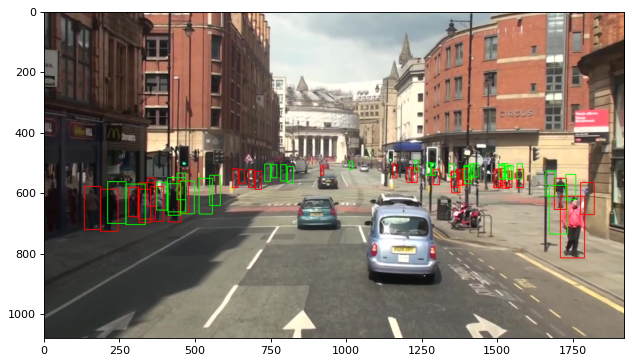

In [5]:
import matplotlib.pyplot as plt

tracks  = boxloader.raw_tracks
print(tracks.shape)

print(ecc_coefs[0, :])
num      = 200
trks     = tracks[:,:num,:]

ecc_coef = ecc_coefs[:num, :]

print(ecc_coef.shape, trks.shape)
x        = map_to_ref(ecc_coef, trks, dsample = 4)

print(x.shape)


# test for the first two frames
frame_id = 99
frame    = cv.imread(img_dir + '/{:06d}.jpg'.format(frame_id +1))
frame    = cv2.cvtColor(frame, cv.COLOR_RGB2BGR)
draw_fr  = frame.copy()
# box      = tracks[:,frame_id, :]
box      = x[:, frame_id, :]
box0     = trks[:, frame_id, :]
box_mask = box[:, -1] > 0
print(f'boxes: {box_mask.sum()}')
print(box.shape, box[0, :])

draw_boxes(draw_fr, box0[box_mask], color = (255, 0, 0), thickness = 2)
draw_boxes(draw_fr, box[box_mask], color = (0,    255, 0), thickness = 2)


fig = plt.figure(figsize=(8, 8), dpi=80, tight_layout=True)
font_size = 20
ax = fig.subplots(1, 1)
cax = ax.imshow(draw_fr)

In [6]:
# print out ecc coefficients
frame_ids = [0, 49, 50, 51, 99]
for frame_id in frame_ids:
    print(f'frame_id: {frame_id}, ecc:')
    print(ecc_coefs[frame_id, :, :].round(5))

frame_id: 0, ecc:
[[ 1.629870e+00 -1.405900e-01 -8.701085e+01]
 [ 1.224200e-01  1.358530e+00 -4.732365e+01]
 [ 9.800000e-04 -5.100000e-04  9.862600e-01]]
frame_id: 49, ecc:
[[ 1.00349e+00 -5.38000e-03 -7.00690e-01]
 [ 2.17000e-03  9.99900e-01 -3.28380e-01]
 [-0.00000e+00 -2.00000e-05  1.00000e+00]]
frame_id: 50, ecc:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
frame_id: 51, ecc:
[[9.96000e-01 3.32000e-03 1.20568e+00]
 [1.58000e-03 9.95270e-01 3.40950e-01]
 [0.00000e+00 2.00000e-05 1.00000e+00]]
frame_id: 99, ecc:
[[ 1.212410e+00  2.096000e-02  1.113429e+01]
 [ 7.102000e-02  1.036060e+00 -5.680370e+00]
 [ 5.800000e-04  1.500000e-04  9.989900e-01]]
